In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np

/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# read in "realistierter Stromverbrauch" 
df = pd.read_csv("data/Realisierter_Stromverbrauch_202103010000_202503270000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df = df[["Datum von", "Netzlast [MWh] Berechnete Auflösungen", "Residuallast [MWh] Berechnete Auflösungen"]].copy()
df = df.rename(columns={"Datum von":"timestamp"})
df = df.drop_duplicates(subset=["timestamp"], keep="first")
df = df.melt(id_vars="timestamp", var_name="item_id", value_name="target")
# encode item id
df["item_id"] = pd.factorize(df["item_id"])[0]

In [22]:
# only get a single time series
df = df[df["item_id"] == 0].copy() 

In [ ]:
# alternatively could also read in Großhandelspreise from 2015-2025
df_1 = pd.read_csv("data/Gro_handelspreise_201501010000_202101010000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df_2 = pd.read_csv("data/Gro_handelspreise_202001010000_202504060000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df = pd.concat([df_1, df_2])
df = df.rename(columns={"Datum von":"timestamp"})
df = df.drop(columns="Datum bis")
df = df.drop_duplicates(subset=["timestamp"], keep="first")
# unpivot data frame
df = df.melt(id_vars="timestamp", var_name="item_id", value_name="target")
# encode item id
df["item_id"] = pd.factorize(df["item_id"])[0]

In [ ]:
df.tail(20)

,timestamp,target,item_id
35668,2025-03-26 04:00:00,46351.50,0
35669,2025-03-26 05:00:00,49857.25,0
35670,2025-03-26 06:00:00,56725.50,0
35671,2025-03-26 07:00:00,60778.00,0
35672,2025-03-26 08:00:00,63646.00,0
35673,2025-03-26 09:00:00,64506.75,0
35674,2025-03-26 10:00:00,65507.25,0
35675,2025-03-26 11:00:00,66186.00,0
35676,2025-03-26 12:00:00,65441.00,0
35677,2025-03-26 13:00:00,64230.50,0


In [23]:
# create TimesSeriesDataFrame
data = TimeSeriesDataFrame(df)
# split data in train and test
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2023"))

In [7]:
last_date = data.index.get_level_values("timestamp").max()
data_train, data_test = data.split_by_time(last_date)

# Chronos Bolt Zero Shot

In [ ]:
from src.predictors.chronos import Chronos

In [7]:
chronos = Chronos(model_name="amazon/chronos-bolt-tiny",
                  device_map="mps",
                  lead_times=np.arange(1, 65),
                  freq=pd.Timedelta("1h"))

# get zero shot predictions on training dataset - used for postprocessing
predictions_train = chronos.predict(data=data_train,
                                    predict_only_last_timestep=False,
                                    previous_context_data=None)

# get zero shot perdictions on test dataset
predictions_raw = chronos.predict(data=data_test,
                                  predict_only_last_timestep=False,
                                  previous_context_data=data_train)

Predicting: 100%|██████████| 676/676 [00:27<00:00, 24.24it/s]


In [8]:
predictions_raw.get_crps(mean=True)

3739.0126741946274

In [ ]:
# add a abstract predictor -- done
# update repo structure
# add a variable with "predict_only_last_timestep: bool" -- done
# add a get last prediction for PredictionLeadTimes

In [ ]:
predictions_raw.results[64].to_dataframe()

0.1           0.2           0.3  \
item_id timestamp                                                       
0       2025-01-01 00:00:00  51515.937500  53629.890625  54920.093750   
        2025-01-01 01:00:00  52585.441406  54787.898438  56157.140625   
        2025-01-01 02:00:00  52939.851562  55153.238281  56493.855469   
        2025-01-01 03:00:00  51779.480469  53786.039062  54972.765625   
        2025-01-01 04:00:00  49335.484375  51222.843750  52383.718750   
...                                   ...           ...           ...   
1       2025-03-26 19:00:00   7186.466797  13486.367188  17824.292969   
        2025-03-26 20:00:00   5403.183594  11248.941406  15296.046875   
        2025-03-26 21:00:00   5704.648438  11559.798828  15592.187500   
        2025-03-26 22:00:00   6966.986328  12866.597656  16938.792969   
        2025-03-26 23:00:00  10322.818359  16491.472656  20739.849609   

                                      0.4           0.5           0.6  \
item_id timestamp                                                       
0       2025-01-01 00:00:00  55951.718750  56886.781250  57823.683594   
        2025-01-01 01:00:00  57239.312500  58224.148438  59198.285156   
        2025-01-01 02:00:00  57509.343750  58427.640625  59335.707031   
        2025-01-01 03:00:00  55853.980469  56668.855469  57490.089844   
        2025-01-01 04:00:00  53283.359375  54140.535156  55019.218750   
...                                   ...           ...           ...   
1       2025-03-26 19:00:00  21411.218750  24689.361328  27974.355469   
        2025-03-26 20:00:00  18667.093750  21771.048828  24930.714844   
        2025-03-26 21:00:00  18953.125000  22079.218750  25254.031250   
        2025-03-26 22:00:00  20288.091797  23421.882812  26557.746094   
        2025-03-26 23:00:00  24234.460938  27576.945312  30884.679688   

                                      0.7           0.8           0.9  \
item_id timestamp                                                       
0       2025-01-01 00:00:00  58871.125000  60113.343750  61900.062500   
        2025-01-01 01:00:00  60279.144531  61563.339844  63414.648438   
        2025-01-01 02:00:00  60350.890625  61577.695312  63419.203125   
        2025-01-01 03:00:00  58444.847656  59615.628906  61413.351562   
        2025-01-01 04:00:00  56057.460938  57315.203125  59255.527344   
...                                   ...           ...           ...   
1       2025-03-26 19:00:00  31405.626953  35470.621094  41304.234375   
        2025-03-26 20:00:00  28205.394531  32140.820312  37732.582031   
        2025-03-26 21:00:00  28603.320312  32646.417969  38330.265625   
        2025-03-26 22:00:00  29896.666016  33872.742188  39533.007812   
        2025-03-26 23:00:00  34434.257812  38590.500000  44573.679688   

                                prediction_date    target  
item_id timestamp                                          
0       2025-01-01 00:00:00 2025-01-03 16:00:00  62027.50  
        2025-01-01 01:00:00 2025-01-03 17:00:00  63925.25  
        2025-01-01 02:00:00 2025-01-03 18:00:00  62882.25  
        2025-01-01 03:00:00 2025-01-03 19:00:00  61434.00  
        2025-01-01 04:00:00 2025-01-03 20:00:00  58695.00  
...                                         ...       ...  
1       2025-03-26 19:00:00 2025-03-29 11:00:00       NaN  
        2025-03-26 20:00:00 2025-03-29 12:00:00       NaN  
        2025-03-26 21:00:00 2025-03-29 13:00:00       NaN  
        2025-03-26 22:00:00 2025-03-29 14:00:00       NaN  
        2025-03-26 23:00:00 2025-03-29 15:00:00       NaN  

[4080 rows x 11 columns]

In [ ]:
# calculate crps for all lead times (1 to 64)
predictions_raw.get_crps()

{1: 610.9805575132488,
 2: 742.4406611655071,
 3: 829.9224722208914,
 4: 904.1520186920498,
 5: 959.9397150006992,
 6: 1007.4405466962162,
 7: 1047.884724032335,
 8: 1073.5045833834688,
 9: 1101.4484039078827,
 10: 1132.4098035491281,
 11: 1155.4083734102362,
 12: 1178.2848071470867,
 13: 1195.3910235089504,
 14: 1216.7903347266426,
 15: 1230.3577643224285,
 16: 1236.3593273015522,
 17: 1248.4873919000954,
 18: 1262.1755346729487,
 19: 1267.8570901209825,
 20: 1275.900888302342,
 21: 1275.7834781545864,
 22: 1281.1575203607445,
 23: 1291.4816436807332,
 24: 1302.3583035945821,
 25: 1332.0674342492769,
 26: 1357.656161912811,
 27: 1380.5721380640007,
 28: 1403.4240257742993,
 29: 1423.1121584718385,
 30: 1440.3695572841157,
 31: 1447.1244597036014,
 32: 1449.3579559794862,
 33: 1452.8370848504314,
 34: 1456.8768961720434,
 35: 1466.4371808400795,
 36: 1470.0551372431512,
 37: 1470.882833739279,
 38: 1479.9764065721604,
 39: 1486.7771497493154,
 40: 1493.6471835776847,
 41: 1496.49232435

In [ ]:
# alternatively only get results for certain lead times (in h)
predictions_raw.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 610.9805575132488,
 12: 1178.2848071470867,
 24: 1302.3583035945821,
 32: 1449.3579559794862,
 48: 1512.9513111515685,
 64: 1661.3293946201293}

In [ ]:
# get empirical coverage rates
predictions_raw.get_empirical_coverage_rates([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,0.025993,0.080584,0.078950,0.081861,0.090236,0.096824
0.2,0.099071,0.176846,0.180625,0.165509,0.181289,0.175467
0.3,0.204525,0.266827,0.281943,0.251558,0.276478,0.259524
0.4,0.327801,0.362731,0.379941,0.341027,0.373251,0.349147
0.5,0.466755,0.459248,0.468696,0.429629,0.468287,0.443468
0.6,0.612144,0.561587,0.569554,0.522010,0.563987,0.543407
0.7,0.754826,0.673476,0.669595,0.624860,0.664079,0.650700
0.8,0.880349,0.789807,0.781126,0.738893,0.768614,0.759779
0.9,0.972066,0.911245,0.907211,0.875447,0.895823,0.884384


<Figure size 800x800 with 0 Axes>

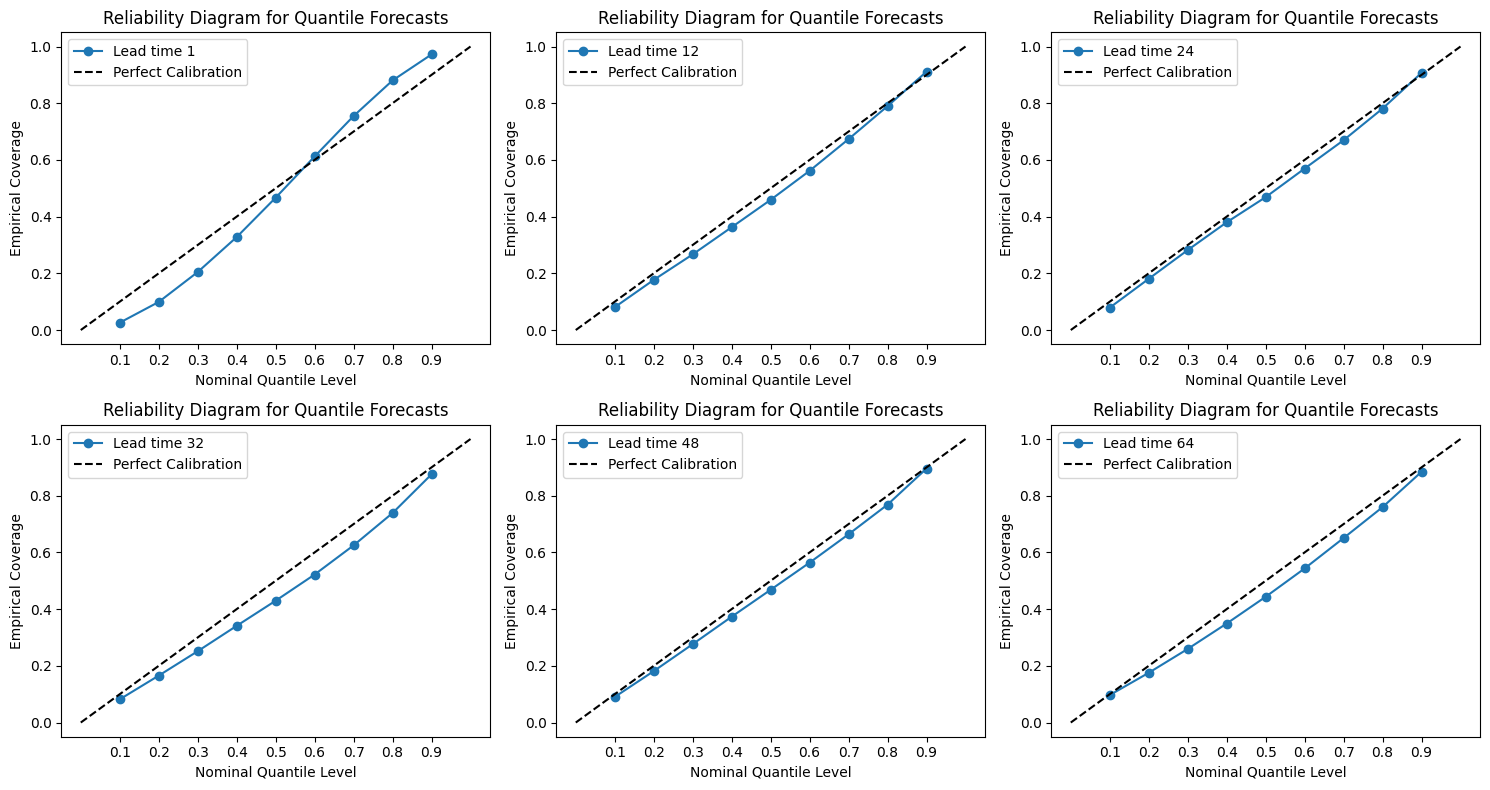

In [ ]:
# plot reliability diagrams
predictions_raw.get_reliability_diagram([1, 12, 24, 32, 48, 64])

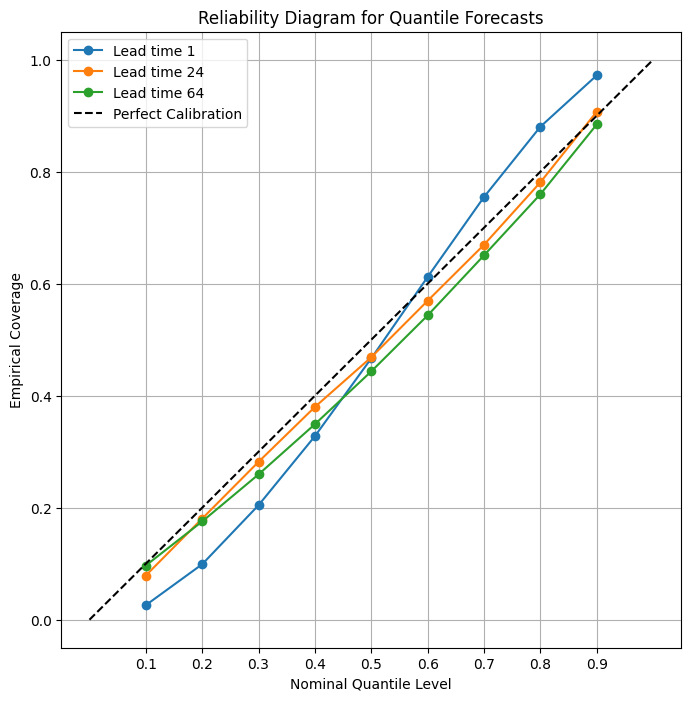

In [ ]:
# use overlay
predictions_raw.get_reliability_diagram([1, 24, 64], overlay=True)

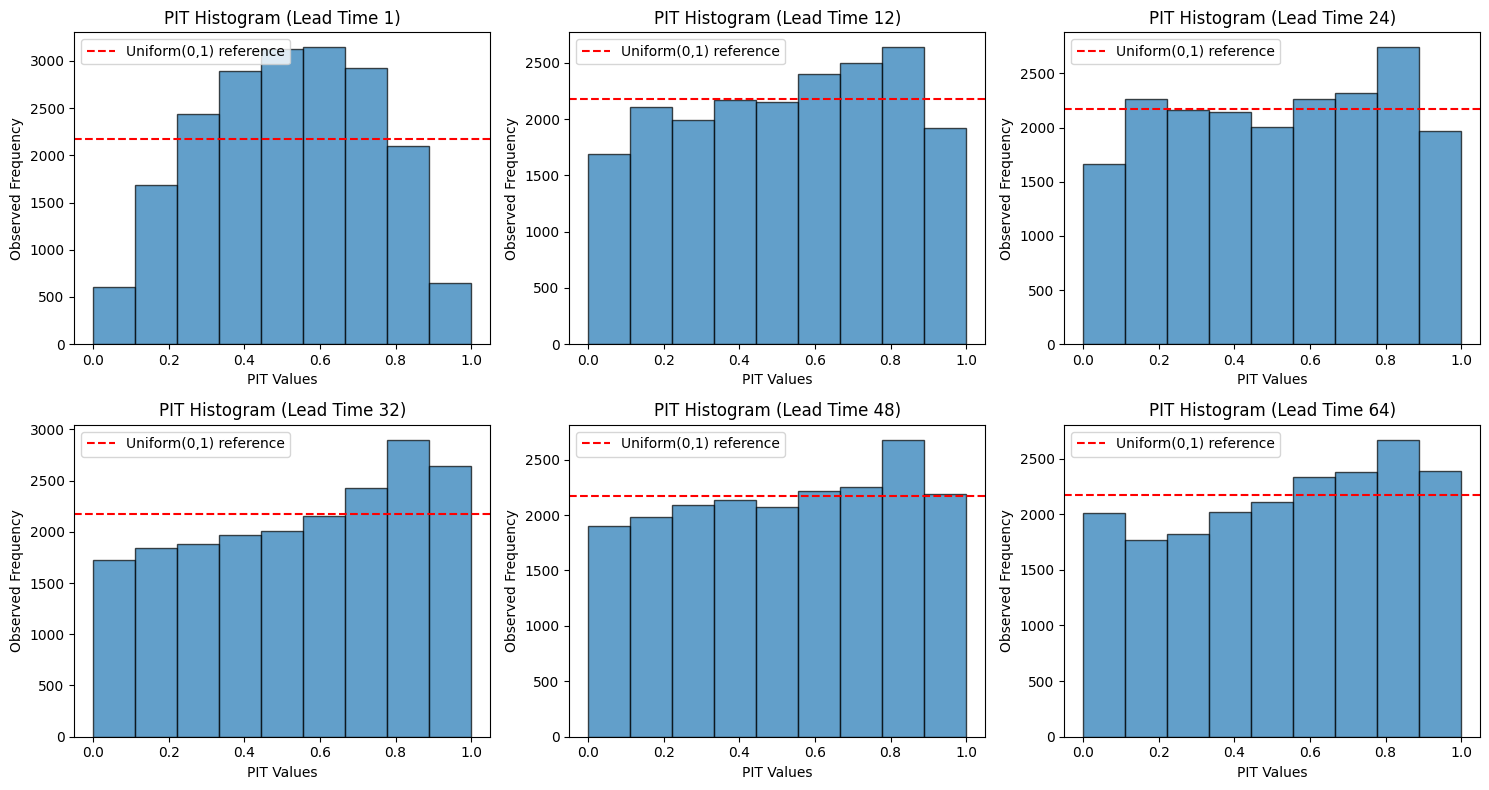

In [ ]:
# plot PIT histograms
predictions_raw.get_pit_histogram([1, 12, 24, 32, 48, 64])

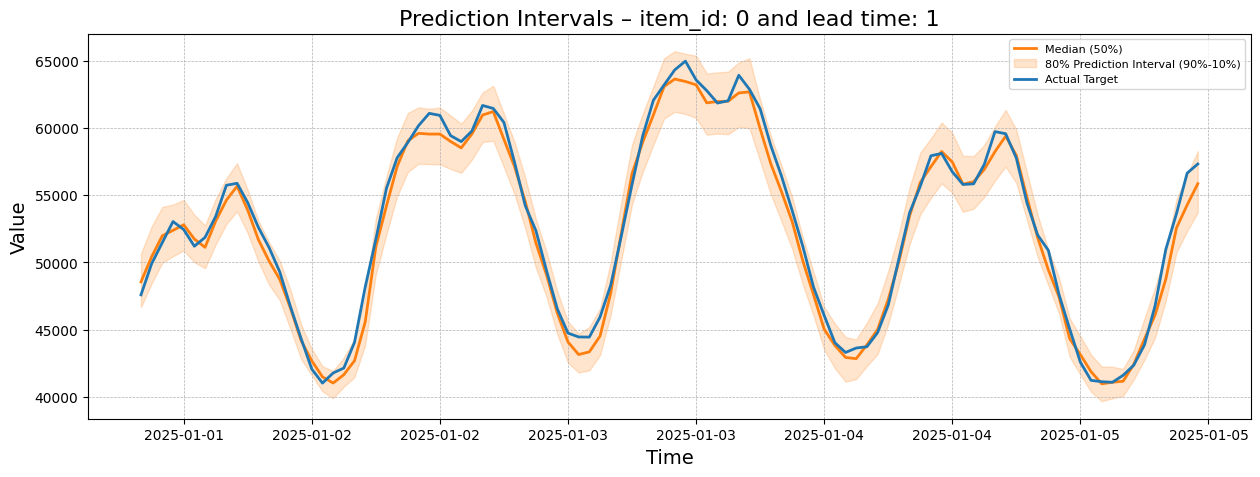

In [ ]:
# plot random subset of the predictions
predictions_raw.results[1].get_random_plot(0)

# Postprocessing

## Parametric Approximation of Log-Normal Distribution
- (V1) Fitte Normalverteilung für log Y, mit folgender Parametrisierung: mean = a + b*M, wobei M = Median-Vorhersage des Modells für log Y. Standardabweichung = c + d*IQR, wobei IQR = Interquartilsabstand (z.B. 90%-10%) des Modells für log Y. Falls sich die Modellvorhersagen anfangs auf Y (statt log Y) beziehen kannst Du die einfach logarithmieren, das ist einer der Vorteile von Quantilen.

In [ ]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from src.postprocessors.mle import PostprocessorMLE

check if data is normally distributed

In [ ]:
# get target variable
log_target = np.log(predictions_train.results[1].data["target"])

<Axes: >

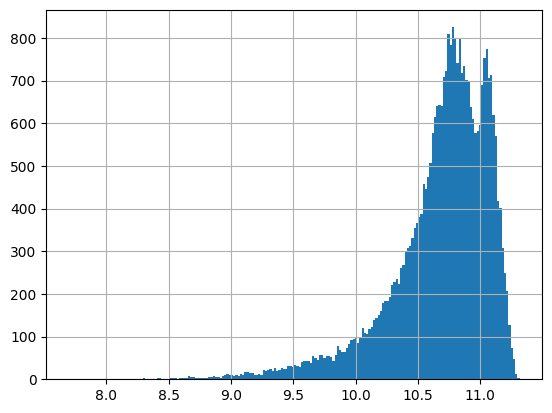

In [ ]:
# plot histogram of target variable
log_target.hist(bins=200)

In [ ]:
# q-q plot
qqplot(log_target, line='s')
plt.show()

In [11]:
postprocessor_mle = PostprocessorMLE()
postprocessor_mle.fit(data=predictions_train)
predictions_nrml = postprocessor_mle.postprocess(data=predictions_raw)

100%|██████████| 64/64 [00:10<00:00,  6.12it/s]


In [17]:
predictions_nrml.get_crps(mean=True)

3716.7094362687158

In [19]:
predictions_nrml.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 842.3982713176011,
 12: 3167.5440630130593,
 24: 3690.095211567144,
 32: 4073.851781436207,
 48: 4235.090331586178,
 64: 4432.397776248821}

<Figure size 800x800 with 0 Axes>

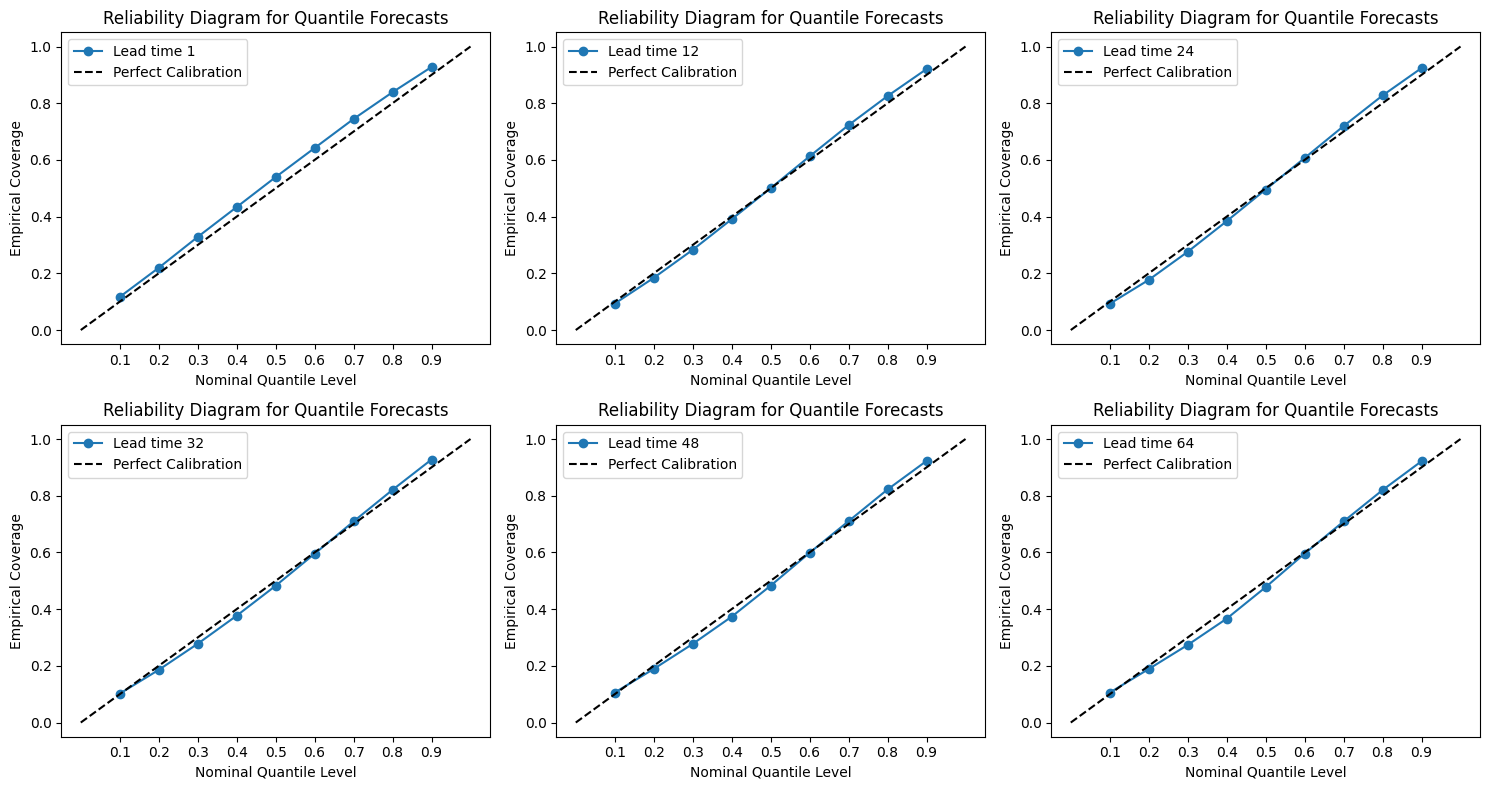

In [20]:
predictions_nrml.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

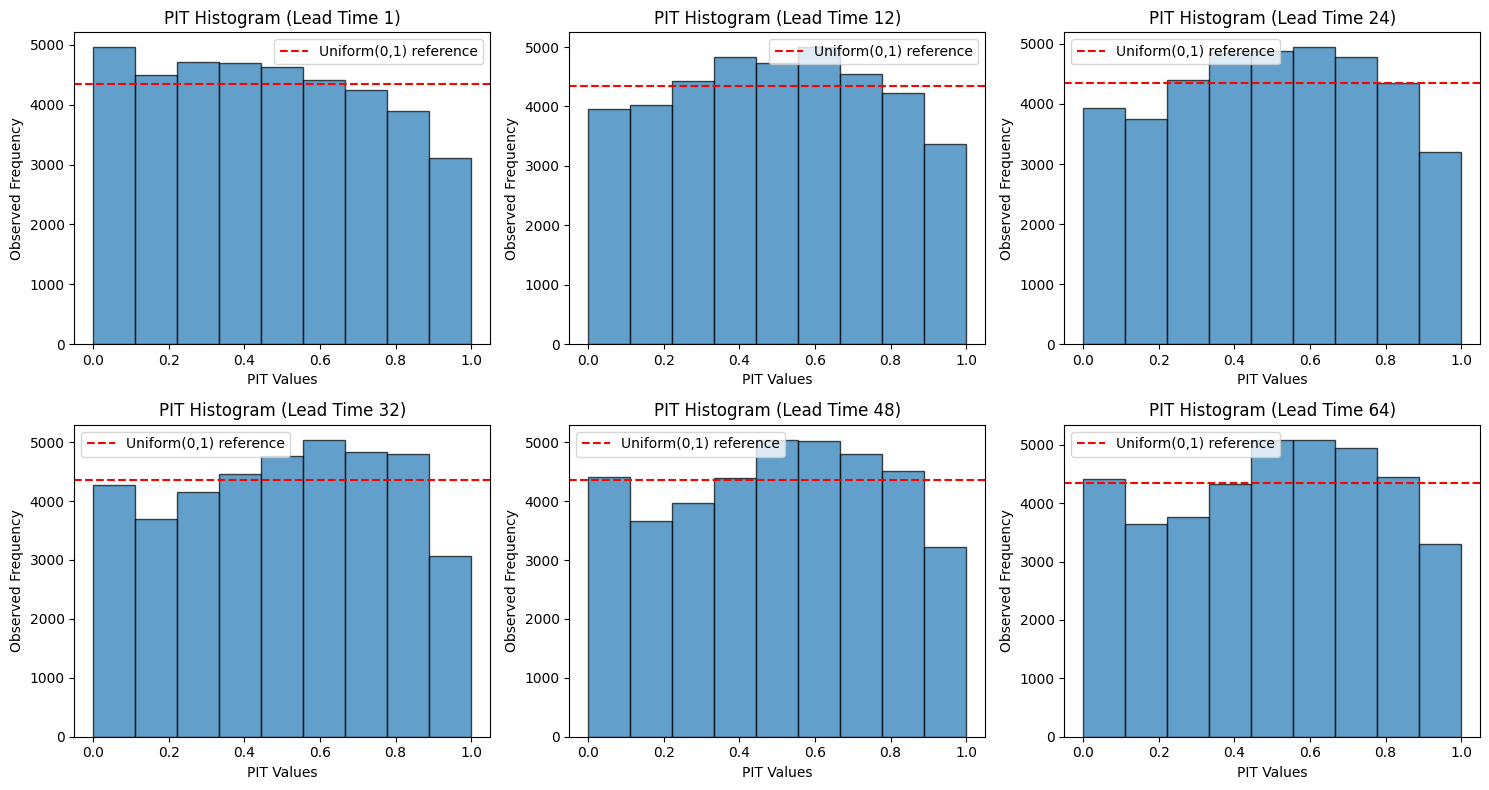

In [21]:
predictions_nrml.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

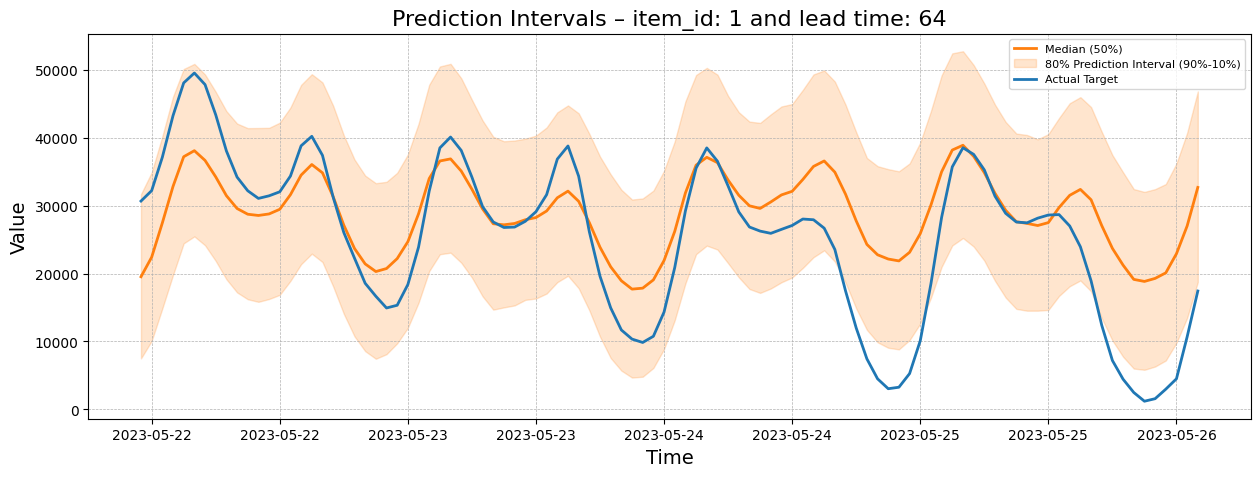

In [33]:
# plot a random part of the predictions
predictions_nrml.results[64].get_random_plot(1)

## Quantile Regression

-  (V2) Fitte separate Quantilsregression für jedes Quantil (z.B. 10%, 20%, ..., 90%). D.h. für jedes Level eine Quantilsregression mit Konstante und einem Regressor (= Quantils-Vorhersage des Modells). Der Spezialfall mit Konstante = 0 und Slope = 1 würde dann heißen, dass die Vorhersagen bereits perfekt kalibriert sind.



In [ ]:
from src.postprocessors.qr import PostprocessorQR

In [44]:
postprocessor_qr = PostprocessorQR()
postprocessor_qr.fit(data=predictions_train)
predictions_qr = postprocessor_qr.postprocess(data=predictions_raw)

100%|██████████| 64/64 [00:03<00:00, 21.01it/s]


In [41]:
predictions_qr.get_crps(mean=True)

3700.3128077628203

In [45]:
predictions_qr.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 844.2101167990203,
 12: 3154.453878488149,
 24: 3674.4300296411398,
 32: 4057.0592555246835,
 48: 4211.263239840049,
 64: 4413.562187045591}

In [46]:
predictions_qr.get_quantile_scores([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,256.343306,962.582151,1137.107656,1237.908843,1295.799435,1346.369107
0.2,395.064403,1476.886720,1735.958977,1925.873670,2017.885867,2104.113211
0.3,481.520486,1802.897058,2107.270367,2358.269997,2463.704825,2580.052345
0.4,526.997463,1983.406704,2311.581044,2590.447344,2690.398397,2819.647731
0.5,539.347251,2031.410803,2367.509606,2636.940873,2726.951649,2857.809917
0.6,518.685932,1948.917570,2273.099076,2507.836290,2593.999150,2720.447328
0.7,465.685669,1739.217655,2020.239491,2213.278333,2287.002866,2401.365451
0.8,376.019651,1387.704275,1599.078908,1735.305075,1791.008319,1889.016412
0.9,239.281365,862.019518,983.090008,1050.906226,1083.934071,1142.208340


In [53]:
predictions_qr.get_empirical_coverage_rates([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,0.108007,0.101649,0.102620,0.101445,0.097641,0.102313
0.2,0.220304,0.206695,0.201205,0.204116,0.199214,0.202252
0.3,0.331810,0.308217,0.302701,0.309034,0.299995,0.300403
0.4,0.435859,0.411705,0.409585,0.412317,0.400470,0.397993
0.5,0.540905,0.509499,0.512767,0.509958,0.503575,0.501328
0.6,0.638443,0.607522,0.610688,0.609718,0.607446,0.605658
0.7,0.739199,0.708661,0.706593,0.704882,0.704397,0.705265
0.8,0.836585,0.804285,0.803340,0.799459,0.807578,0.807195
0.9,0.926438,0.906700,0.902538,0.911730,0.911143,0.906802


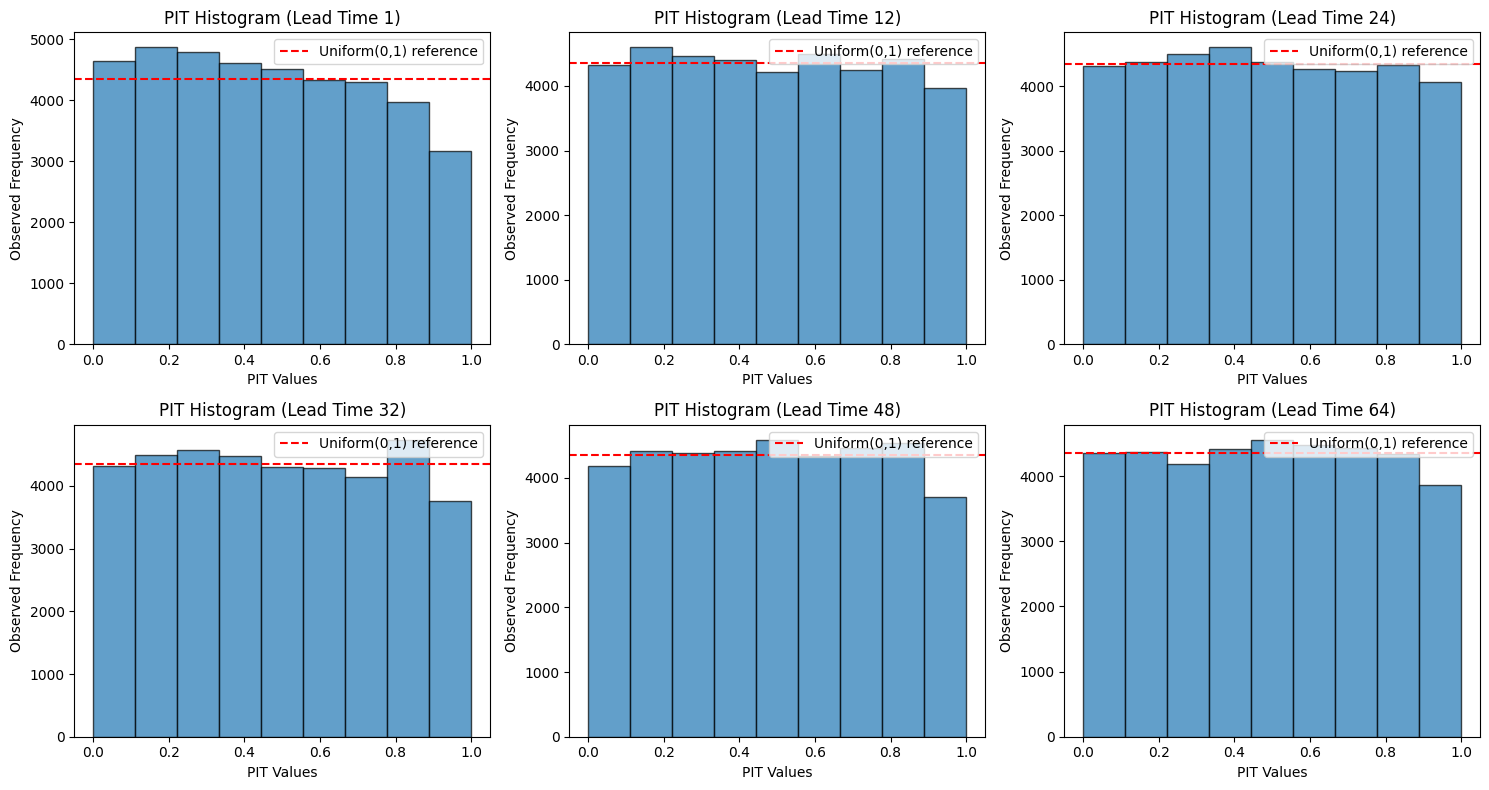

In [47]:
predictions_qr.get_pit_histogram([1, 12, 24, 32, 48, 64])

<Figure size 800x800 with 0 Axes>

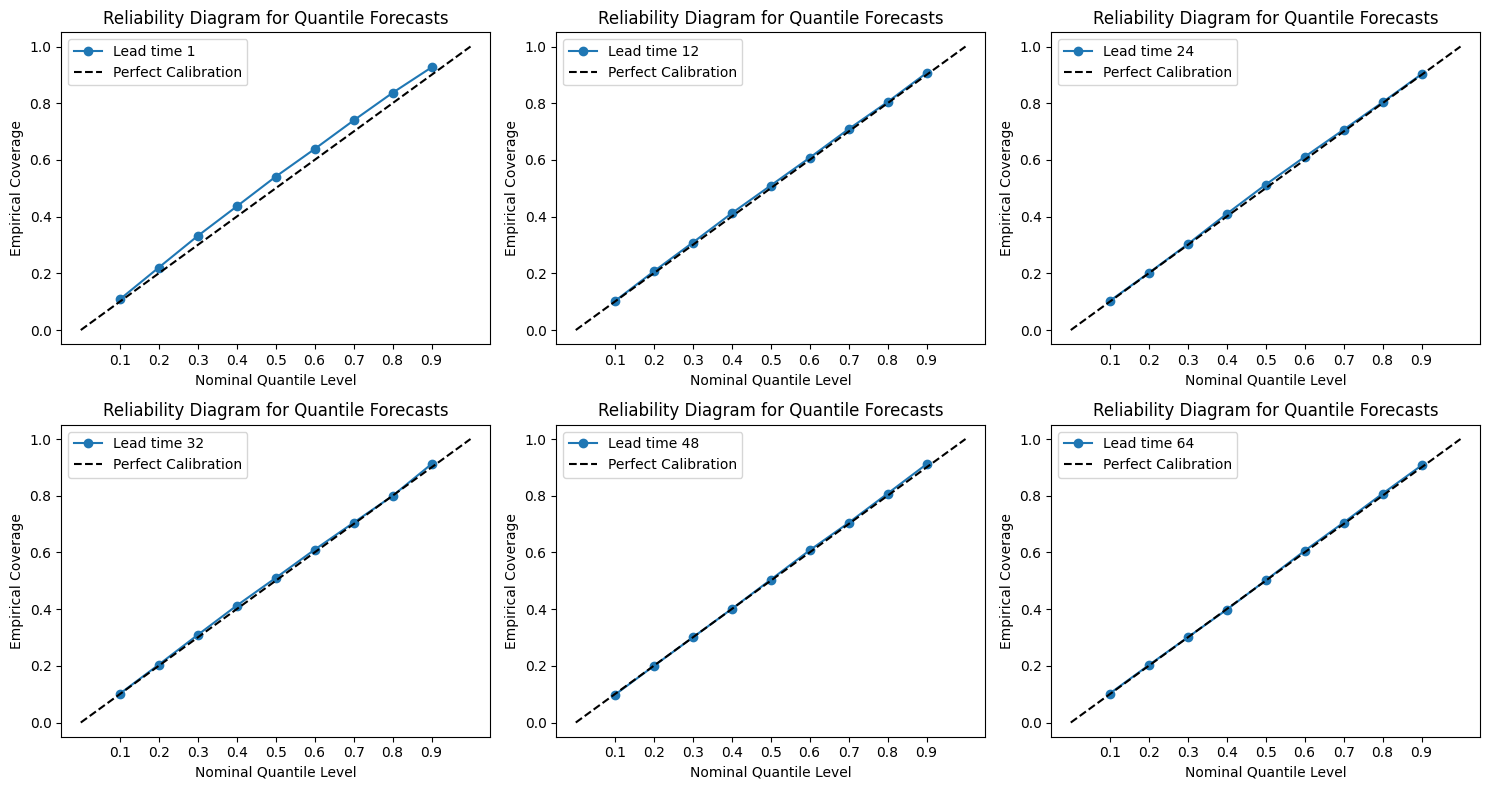

In [52]:
predictions_qr.get_reliability_diagram([1, 12, 24, 32, 48, 64])

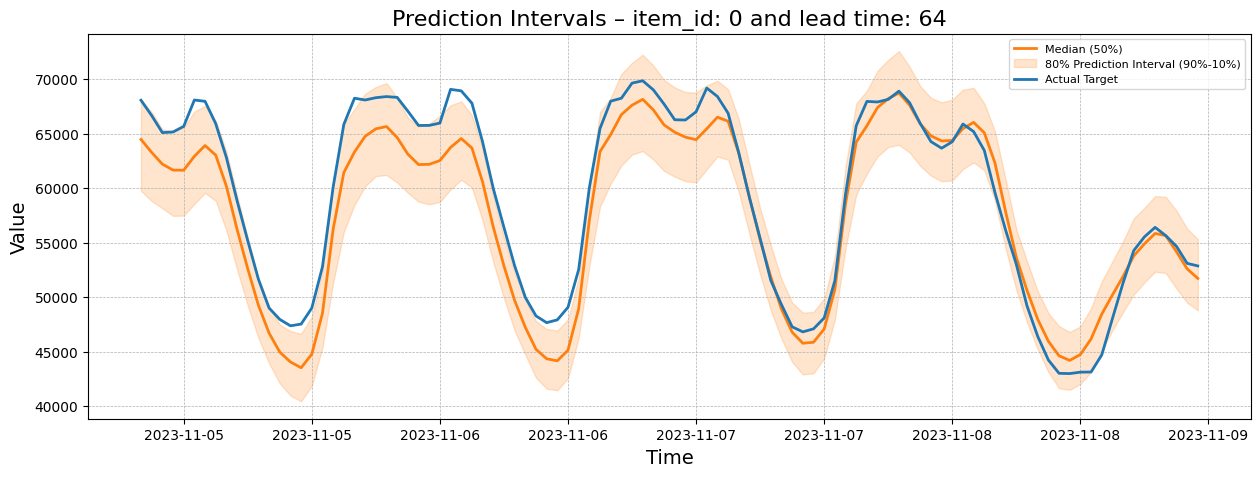

In [51]:
predictions_qr.results[64].get_random_plot()

# Benchmark

## Quantile Regression 

- simple quantile regresssion with seasonal variables (only calculated based on time information)

In [ ]:
from src.predictors.quantile_regression import QuantileRegression

In [24]:
quantreq = QuantileRegression(quantiles = np.arange(0.1, 1, 0.1),
                              lead_times=np.arange(1, 65),
                              freq=pd.Timedelta("1h"))

quantreq.fit(data_train)

  3%|▎         | 2/64 [00:14<07:00,  6.79s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
  6%|▋         | 4/64 [00:33<08:38,  8.64s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
  9%|▉         | 6/64 [00:55<09:19,  9.64s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 33%|███▎      | 21/64 [02:42<05:13,  7.

In [28]:
prediction_benchmark_qr = quantreq.predict(data_test)

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:04<00:00, 14.62it/s]


In [29]:
prediction_benchmark_qr.get_crps(mean=True)

3721.8201659555775

In [39]:
prediction_benchmark_qr.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 3943.5245248800125,
 12: 3888.978907488489,
 24: 3803.948221943183,
 32: 3628.1584017766236,
 48: 3745.939224802927,
 64: 3677.5768321880364}

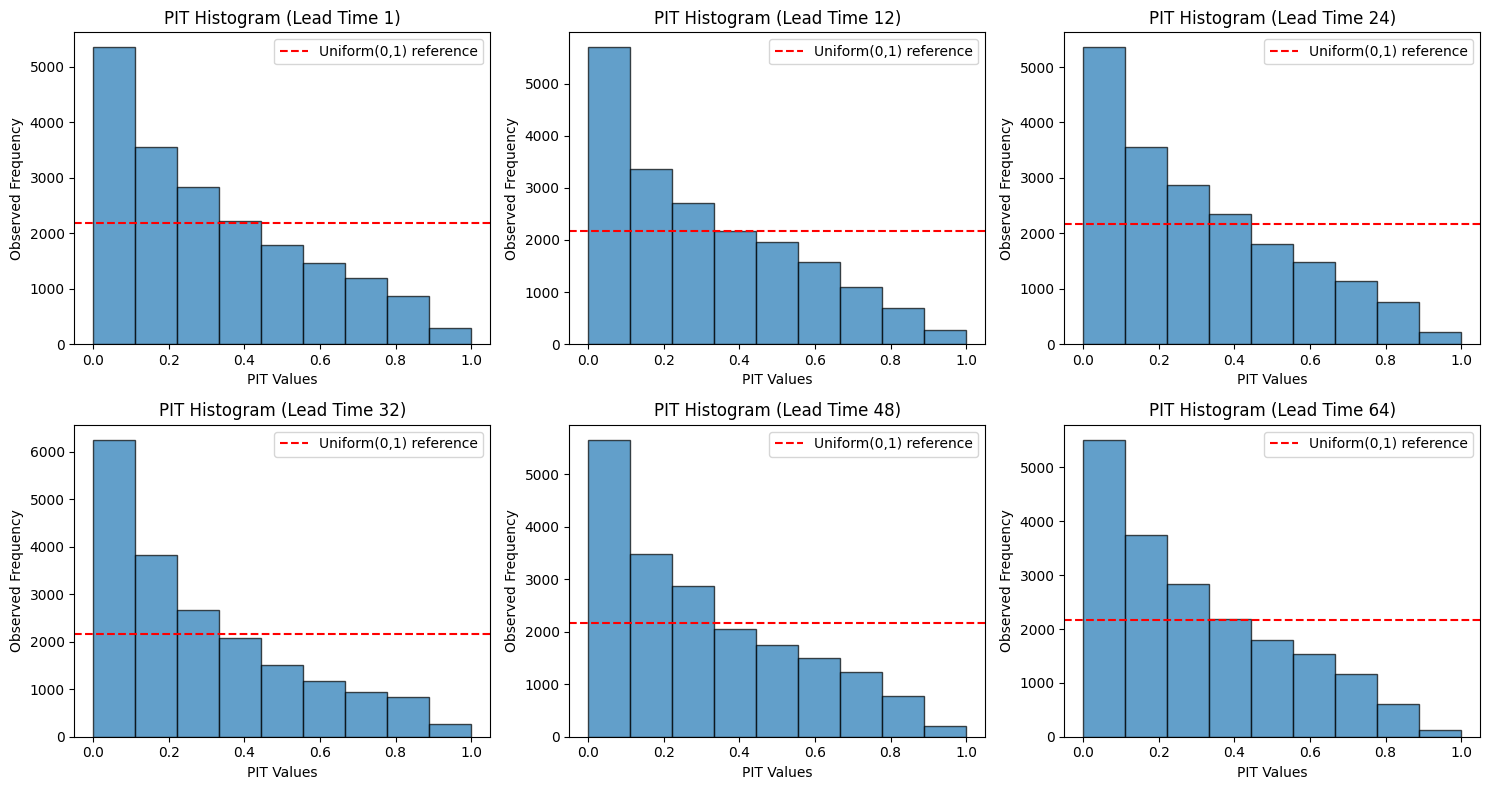

In [30]:
prediction_benchmark_qr.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

<Figure size 800x800 with 0 Axes>

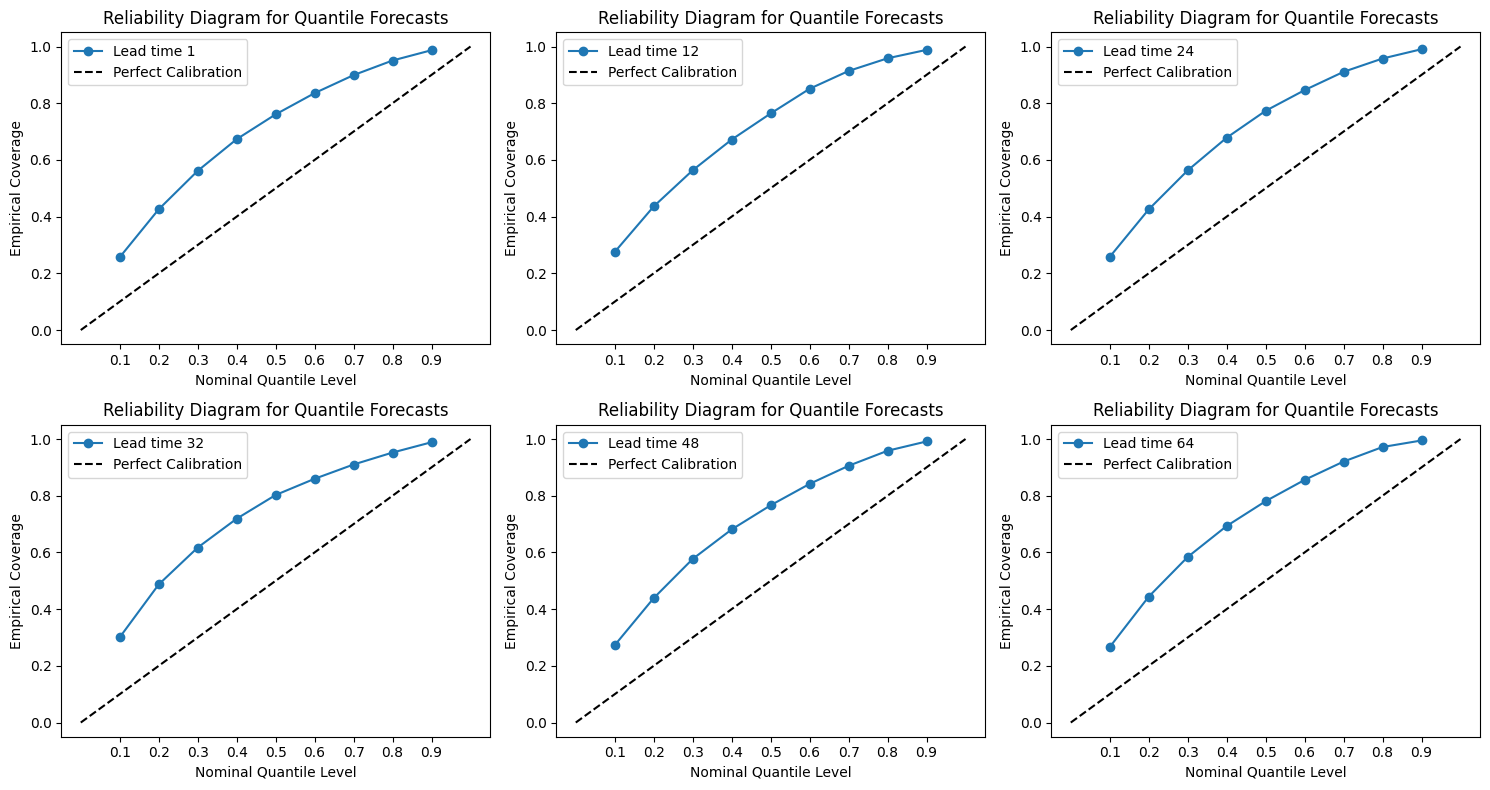

In [38]:
prediction_benchmark_qr.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

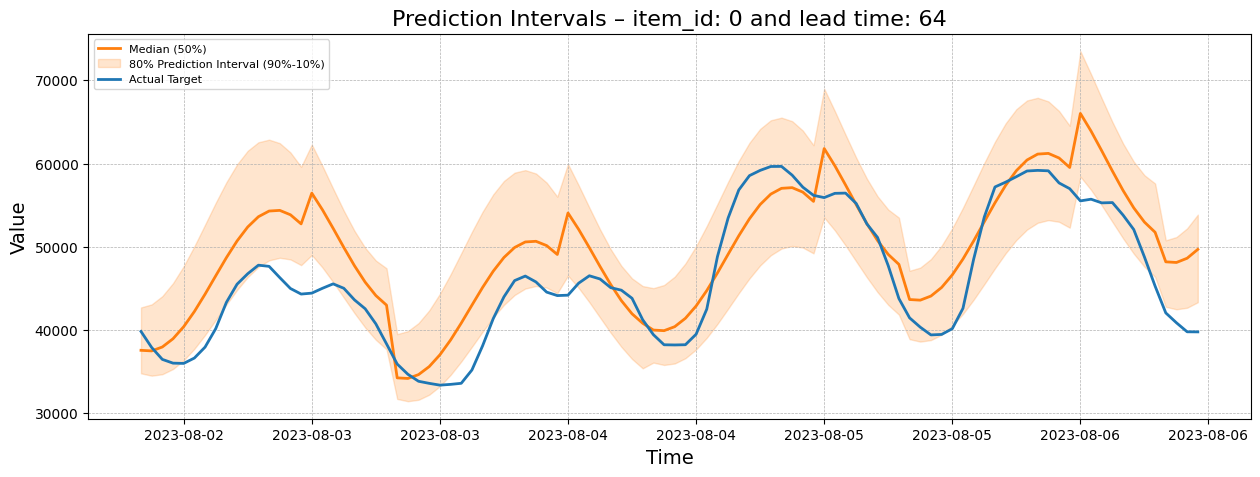

In [37]:
prediction_benchmark_qr.results[64].get_random_plot()

## Nearest Neigbour Approach
- einfacher benchmark
- Berechne empirische Quantile basierend auf den Werten für gleicher Wochentag, gleiche Stunde.

In [62]:
from src.predictors.nearest_neighbour import NNPredictor

In [63]:
nn_predictor = NNPredictor(quantiles = np.arange(0.1, 1, 0.1),
                           lead_times=np.arange(1, 65),
                           freq=pd.Timedelta("1h"))

In [64]:
nn_predictor.fit(data_train)

100%|██████████| 16102/16102 [00:23<00:00, 678.85it/s]


In [65]:
predictions_benchmark_nn = nn_predictor.predict(data_test)

100%|██████████| 19582/19582 [00:28<00:00, 682.80it/s]


In [67]:
predictions_benchmark_nn.get_crps(mean=True)

3093.632639932858

In [68]:
predictions_benchmark_nn.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 3093.3053142527874,
 12: 3092.927692006203,
 24: 3093.4441035062887,
 32: 3092.6198315507563,
 48: 3094.2500680893445,
 64: 3094.9962587352848}

<Figure size 800x800 with 0 Axes>

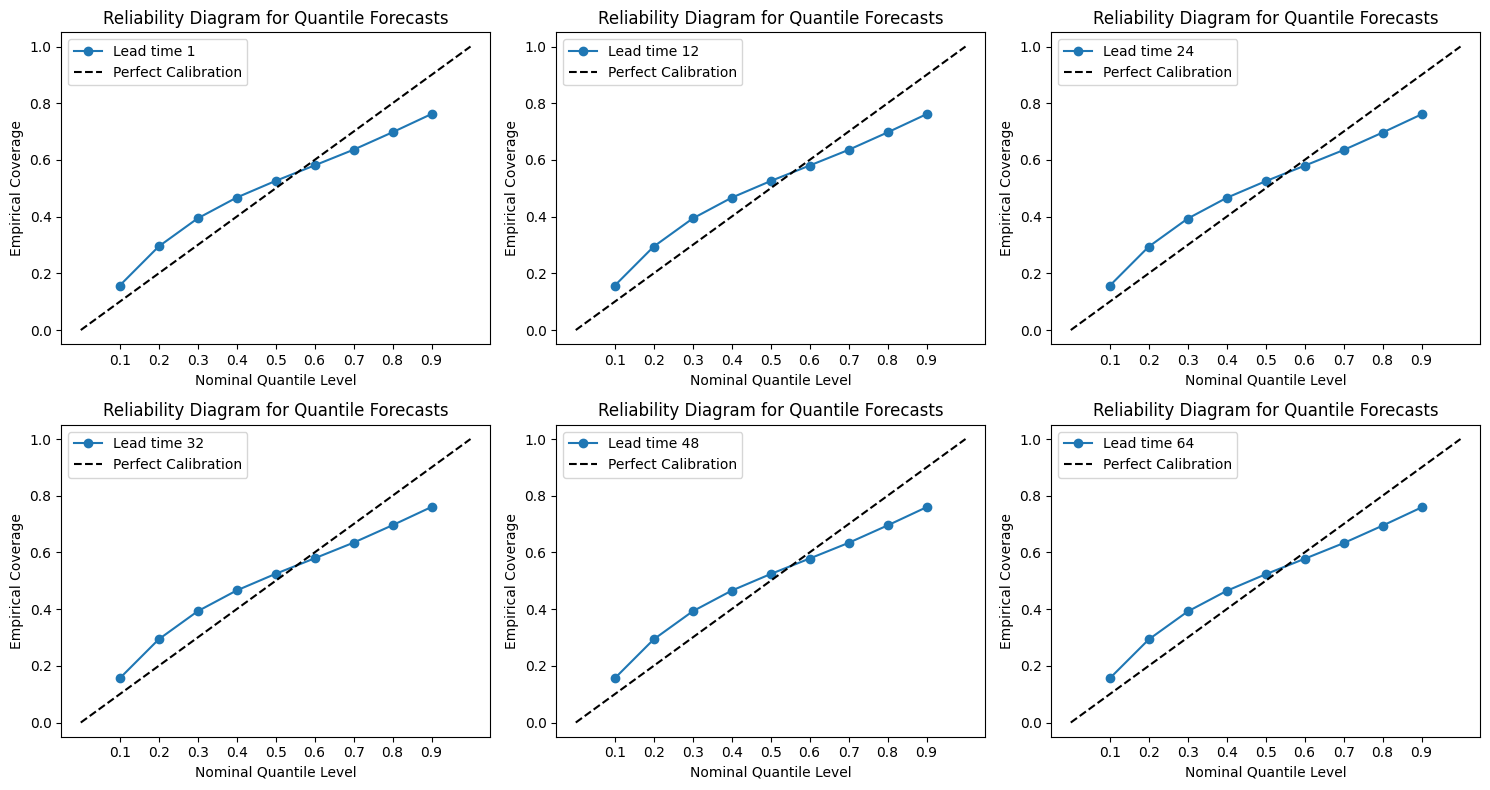

In [58]:
predictions_benchmark_nn.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

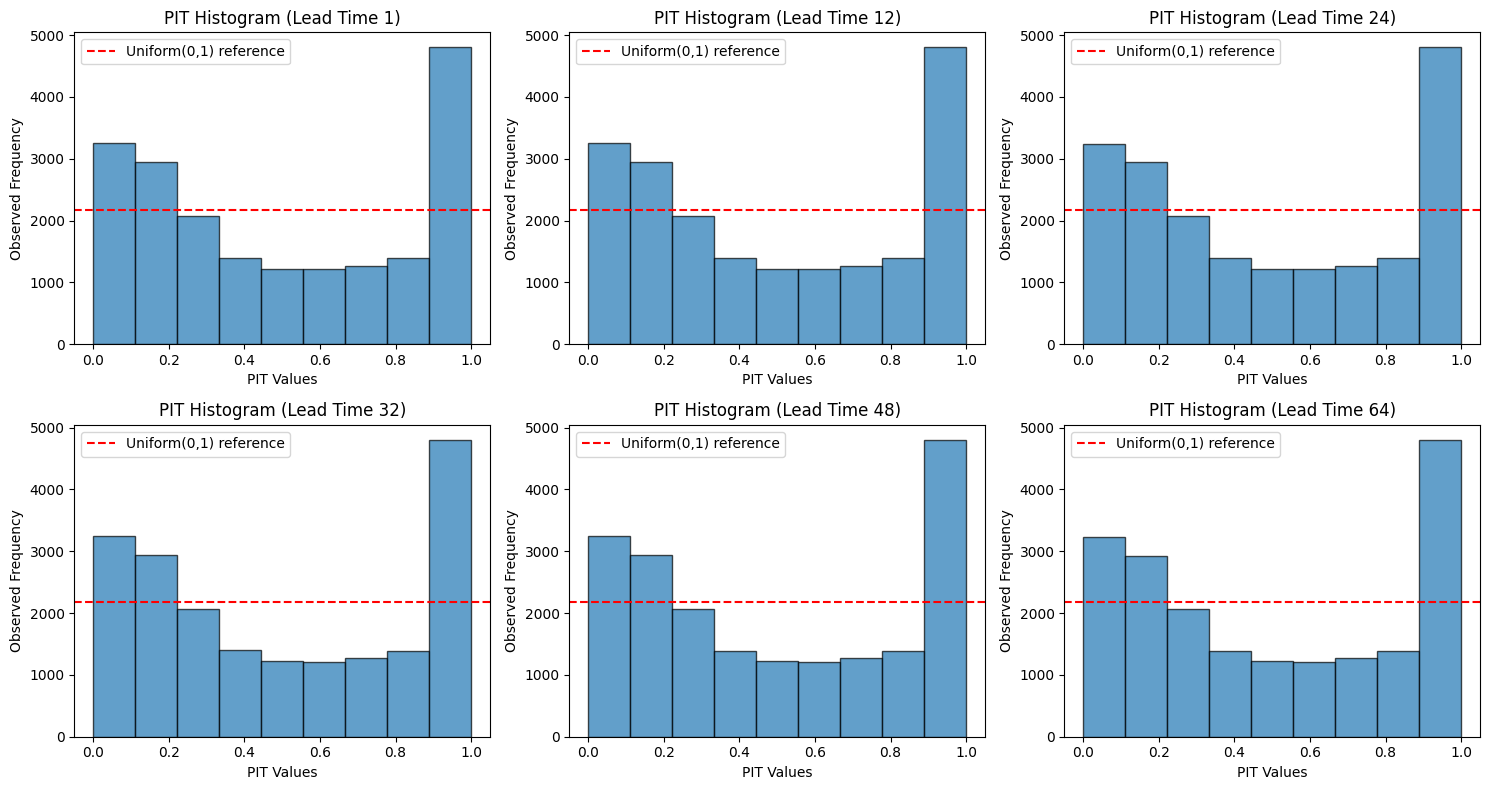

In [59]:
predictions_benchmark_nn.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

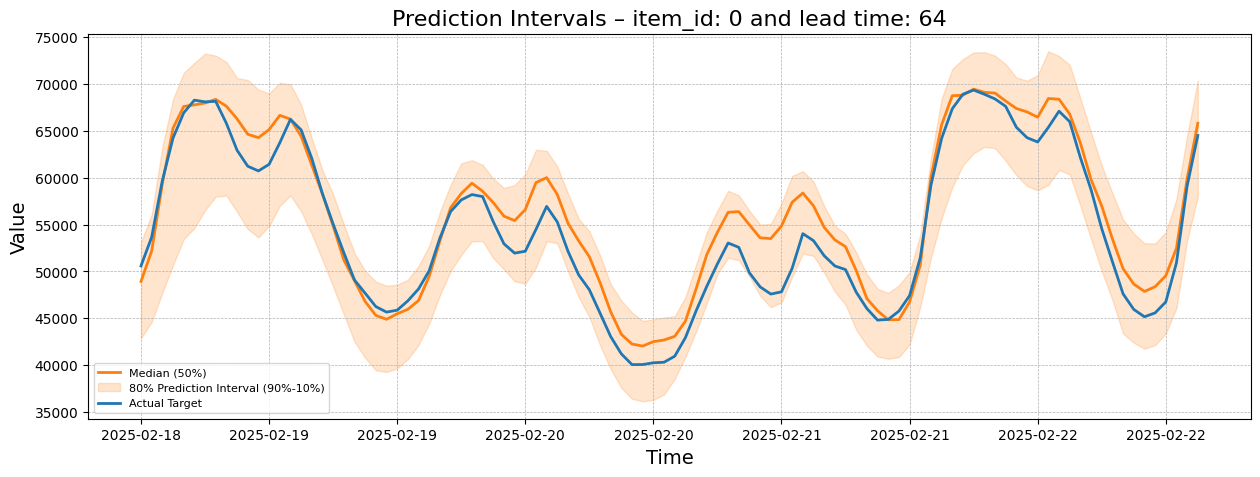

In [60]:
predictions_benchmark_nn.results[64].get_random_plot()